### 1. Take one of the supervised learning models you have built recently and apply at least three dimensionality reduction techniques to it (separately). Be sure to create a short summary of each technique you use. Indicate how each changed the model performance

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split

raw = pd.read_table('../WEEK17/australian.dat', delim_whitespace=True, names=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'])
raw.head(2)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0


In [98]:
X = raw.drop(columns = 'A15')
y = raw['A15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']
columns_to_scale  = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, columns_to_scale),
        ("cat", categorical_transformer, columns_to_encode),
    ]
)

from sklearn.metrics import classification_report, plot_confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state = 42))])

# instantiate grid search with DecisionTreeClassifier(dt): refit = True by default
params_dt = {'classifier__n_estimators' : [50, 100], 'classifier__max_depth': [4, 5, 6], 'classifier__min_samples_leaf': [0.02, 0.04, 0.06, 0.08], 'classifier__max_features': [0.2, 0.4, 0.6, 0.8, 0.9]}
grid_dt = GridSearchCV(estimator = clf, param_grid = params_dt, scoring = 'roc_auc', cv = 10, n_jobs = -1)

grid_dt.fit(X_train, y_train)
best_hyperparams = grid_dt.best_params_
print(f'Best hyperparameters: {best_hyperparams}')

Best hyperparameters: {'classifier__max_depth': 6, 'classifier__max_features': 0.9, 'classifier__min_samples_leaf': 0.02, 'classifier__n_estimators': 100}


In [103]:
best_model = RandomForestClassifier(n_estimators = 100, max_depth = 6, max_features = 0.9, min_samples_leaf = 0.02, random_state = 42)
best_clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", best_model)])
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

test_accuracy = best_clf.score(X_test, y_test) # this one is accuracy, though...
print(f'Test accuracy of the best model: {test_accuracy:.3f}')

print(classification_report(y_test, y_pred))

Test accuracy of the best model: 0.855
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        87
           1       0.80      0.80      0.80        51

    accuracy                           0.86       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.86      0.86      0.86       138



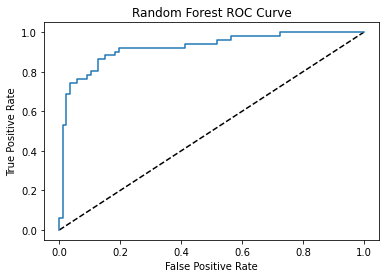

In [104]:
# we can plot the ROC curve for the best model:

y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.plot(fpr, tpr)
_= plt.xlabel('False Positive Rate')
_= plt.ylabel('True Positive Rate')
_= plt.title('Random Forest ROC Curve')
plt.show()

In [105]:
print(f'The AUC score of the best model is: {roc_auc_score(y_test, y_pred_prob):.3f}')

The AUC score of the best model is: 0.923


#### Dimensionality reduction A: PCA (Principal Component Analysis)

In [110]:
from sklearn.decomposition import PCA

clf = Pipeline(steps=[("preprocessor", preprocessor),("pca", PCA(n_components = 0.95)) , ("classifier", RandomForestClassifier(random_state = 42))])

# instantiate grid search with DecisionTreeClassifier(dt): refit = True by default
params_dt = {'classifier__n_estimators' : [50, 100], 'classifier__max_depth': [4, 5, 6], 'classifier__min_samples_leaf': [0.02, 0.04, 0.06, 0.08], 'classifier__max_features': [0.2, 0.4, 0.6, 0.8, 0.9]}
grid_dt = GridSearchCV(estimator = clf, param_grid = params_dt, scoring = 'roc_auc', cv = 10, n_jobs = -1)

grid_dt.fit(X_train, y_train)
best_hyperparams = grid_dt.best_params_
print(f'Best hyperparameters: {best_hyperparams}')

Best hyperparameters: {'classifier__max_depth': 5, 'classifier__max_features': 0.2, 'classifier__min_samples_leaf': 0.02, 'classifier__n_estimators': 100}


In [111]:
best_model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 0.2, min_samples_leaf = 0.02, random_state = 42)
best_clf = Pipeline(steps=[("preprocessor", preprocessor), ("pca", PCA(n_components = 0.95)), ("classifier", best_model)])
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

test_accuracy = best_clf.score(X_test, y_test) # this one is accuracy, though...
print(f'Test accuracy of the best model: {test_accuracy:.3f}')

print(classification_report(y_test, y_pred))

Test accuracy of the best model: 0.841
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        87
           1       0.77      0.80      0.79        51

    accuracy                           0.84       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.84      0.84      0.84       138



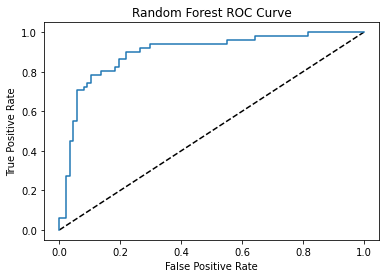

In [112]:
y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.plot(fpr, tpr)
_= plt.xlabel('False Positive Rate')
_= plt.ylabel('True Positive Rate')
_= plt.title('Random Forest ROC Curve')
plt.show()

In [113]:
print(f'The AUC score of the best model is: {roc_auc_score(y_test, y_pred_prob):.3f}')

The AUC score of the best model is: 0.895


#### Dimensionality reduction B: LDA (Linear Discriminant Analysis)

In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = Pipeline(steps=[("preprocessor", preprocessor),("lda", LDA(n_components = 1)) , ("classifier", RandomForestClassifier(random_state = 42))])

# instantiate grid search with DecisionTreeClassifier(dt): refit = True by default
params_dt = {'classifier__n_estimators' : [50, 100], 'classifier__max_depth': [4, 5, 6], 'classifier__min_samples_leaf': [0.02, 0.04, 0.06, 0.08], 'classifier__max_features': [0.2, 0.4, 0.6, 0.8, 0.9]}
grid_dt = GridSearchCV(estimator = clf, param_grid = params_dt, scoring = 'roc_auc', cv = 10, n_jobs = -1)

grid_dt.fit(X_train, y_train)
best_hyperparams = grid_dt.best_params_
print(f'Best hyperparameters: {best_hyperparams}')

Best hyperparameters: {'classifier__max_depth': 4, 'classifier__max_features': 0.2, 'classifier__min_samples_leaf': 0.06, 'classifier__n_estimators': 50}


In [115]:
best_model = RandomForestClassifier(n_estimators = 50, max_depth = 4, max_features = 0.2, min_samples_leaf = 0.06, random_state = 42)
best_clf = Pipeline(steps=[("preprocessor", preprocessor), ("pca", LDA(n_components = 1)), ("classifier", best_model)])
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

test_accuracy = best_clf.score(X_test, y_test) # this one is accuracy, though...
print(f'Test accuracy of the best model: {test_accuracy:.3f}')

print(classification_report(y_test, y_pred))

Test accuracy of the best model: 0.877
              precision    recall  f1-score   support

           0       0.91      0.90      0.90        87
           1       0.83      0.84      0.83        51

    accuracy                           0.88       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



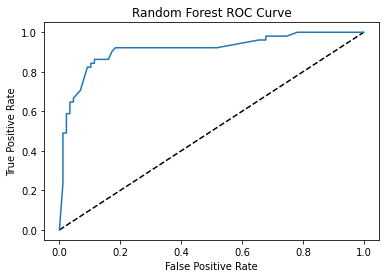

In [116]:
y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.plot(fpr, tpr)
_= plt.xlabel('False Positive Rate')
_= plt.ylabel('True Positive Rate')
_= plt.title('Random Forest ROC Curve')
plt.show()

In [117]:
print(f'The AUC score of the best model is: {roc_auc_score(y_test, y_pred_prob):.3f}')

The AUC score of the best model is: 0.913


#### Dimensionality reduction B: Isomap embedding

In [123]:
from sklearn.manifold import Isomap

clf = Pipeline(steps=[("preprocessor", preprocessor),("isomap", Isomap(n_components = 13)) , ("classifier", RandomForestClassifier(random_state = 42))])

# instantiate grid search with DecisionTreeClassifier(dt): refit = True by default
params_dt = {'isomap__n_components' : [10, 11, 12, 13], 'classifier__n_estimators' : [50, 100], 'classifier__max_depth': [4, 5, 6], 'classifier__min_samples_leaf': [0.02, 0.04, 0.06, 0.08], 'classifier__max_features': [0.2, 0.4, 0.6, 0.8, 0.9]}
grid_dt = GridSearchCV(estimator = clf, param_grid = params_dt, scoring = 'roc_auc', cv = 10, n_jobs = -1)

grid_dt.fit(X_train, y_train)
best_hyperparams = grid_dt.best_params_
print(f'Best hyperparameters: {best_hyperparams}')

Best hyperparameters: {'classifier__max_depth': 5, 'classifier__max_features': 0.6, 'classifier__min_samples_leaf': 0.02, 'classifier__n_estimators': 100, 'isomap__n_components': 13}


In [120]:
best_model = RandomForestClassifier(n_estimators = 100, max_depth = 5, max_features = 0.6, min_samples_leaf = 0.02, random_state = 42)
best_clf = Pipeline(steps=[("preprocessor", preprocessor), ("isomap", Isomap(n_components = 13)), ("classifier", best_model)])
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

test_accuracy = best_clf.score(X_test, y_test) # this one is accuracy, though...
print(f'Test accuracy of the best model: {test_accuracy:.3f}')

print(classification_report(y_test, y_pred))

Test accuracy of the best model: 0.841
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        87
           1       0.78      0.78      0.78        51

    accuracy                           0.84       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.84      0.84      0.84       138



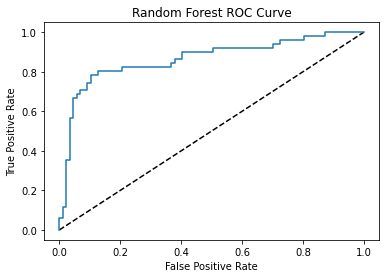

In [121]:
y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
_= plt.plot([0, 1], [0, 1], 'k--')
_= plt.plot(fpr, tpr)
_= plt.xlabel('False Positive Rate')
_= plt.ylabel('True Positive Rate')
_= plt.title('Random Forest ROC Curve')
plt.show()

In [122]:
print(f'The AUC score of the best model is: {roc_auc_score(y_test, y_pred_prob):.3f}')

The AUC score of the best model is: 0.864


Summary: isomap tries to find lower dimensional embedding of the original dataset while maintaining distances between all points in the original dataset. With the n_components parameter we can set the number of features the transformed dataset should have.  Ideally we would iterate through multiple options to optimize, but this runs quite slowly, so I did only for a few values. This did not improve our score, in fact it became a bit worse. 

### 2. Write a function that will indicate if an inputted IPv4 address is accurate or not. IP addresses are valid if they have 4 values between 0 and 255 (inclusive), punctuated by periods.

In [91]:
example = '255.126.0.33' # has to be between 0 and 255 inclusive
type(example)

str

In [92]:
def decider(example):
    totallist = list(example)
    valid = [str(i) for i in list(range(10))] + ['.']
    
    if all(element in valid for element in totallist):
        tolist = example.split('.')
        truthlist = []
    
        if len(tolist) == 4:
            for i in range(len(tolist)):
                truthlist.append(int(tolist[i]) not in list(range(256)))  
            if any(truthlist):
                print('This IP address is not valid!')
            else:
                print('Valid IP address!')
        else:
            print('Not valid format!')
    else:
        print('Not valid format!')

In [93]:
decider(example)

Valid IP address!
